<a href="https://colab.research.google.com/github/JisnaP/Fraud_Detection/blob/main/Fraud_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pyspark seaborn matplotlib pandas

In [ ]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, when, isnan, count, lit
import seaborn as sns
import matplotlib.pyplot as plt

In [ ]:
spark = SparkSession.builder.appName("FraudDetection").getOrCreate()


In [ ]:
file_path ="/content/drive/MyDrive/Fraud (2).csv"

df = spark.read.csv(file_path, header=True, inferSchema=True)


In [ ]:
df.printSchema()
df.show(5)

root
 |-- step: integer (nullable = true)
 |-- type: string (nullable = true)
 |-- amount: double (nullable = true)
 |-- nameOrig: string (nullable = true)
 |-- oldbalanceOrg: double (nullable = true)
 |-- newbalanceOrig: double (nullable = true)
 |-- nameDest: string (nullable = true)
 |-- oldbalanceDest: double (nullable = true)
 |-- newbalanceDest: double (nullable = true)
 |-- isFraud: integer (nullable = true)
 |-- isFlaggedFraud: integer (nullable = true)

+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1| PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1| PA

In [ ]:
df.count()

6362620

In [ ]:
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [ ]:
df = df.fillna(0, subset=["oldbalanceDest", "newbalanceDest"])


In [ ]:



merchant_transactions = df.filter(col("nameDest").startswith("M"))


merchant_count = merchant_transactions.count()

print(f"Number of transactions involving Merchants: {merchant_count}")


Number of transactions involving Merchants: 2151495


In [ ]:
missing_values = df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns])
missing_values.show()

+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|step|type|amount|nameOrig|oldbalanceOrg|newbalanceOrig|nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+
|   0|   0|     0|       0|            0|             0|       0|             0|             0|      0|             0|
+----+----+------+--------+-------------+--------------+--------+--------------+--------------+-------+--------------+



In [ ]:



missing_info_count = df.filter((col("nameDest").startswith("M")) &
                               (col("newbalanceDest").isNull() | (col("newbalanceDest") == 0))
                              ).count()

print(f"Transactions where Merchants have missing newbalanceDest: {missing_info_count}")


Transactions where Merchants have missing newbalanceDest: 2151495


In [ ]:
df.filter((col("nameDest").startswith("M")) &
                               (col("newbalanceDest").isNull() | (col("newbalanceDest") == 0))
                              ).show(5)

+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|   type|  amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+-------+--------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1|PAYMENT| 9839.64|C1231006815|     170136.0|     160296.36|M1979787155|           0.0|           0.0|      0|             0|
|   1|PAYMENT| 1864.28|C1666544295|      21249.0|      19384.72|M2044282225|           0.0|           0.0|      0|             0|
|   1|PAYMENT|11668.14|C2048537720|      41554.0|      29885.86|M1230701703|           0.0|           0.0|      0|             0|
|   1|PAYMENT| 7817.71|  C90045638|      53860.0|      46042.29| M573487274|           0.0|           0.0|      0|             0|
|   1|PAYMENT| 7107.77| C154988899|     183195.0|     176087.23| M408069119|           0.0

No Merchents are Fraud

In [ ]:
fraud_merchant_df = df.filter((col("nameDest").startswith("M")) & (col("isFraud") == 1)).count()

In [ ]:
fraud_merchant_df

0

Merchants are removed from the model building

In [ ]:
df_filtered = df.filter(~col("nameDest").startswith("M"))


In [ ]:
df_filtered.show(10)

+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|step|    type|   amount|   nameOrig|oldbalanceOrg|newbalanceOrig|   nameDest|oldbalanceDest|newbalanceDest|isFraud|isFlaggedFraud|
+----+--------+---------+-----------+-------------+--------------+-----------+--------------+--------------+-------+--------------+
|   1|TRANSFER|    181.0|C1305486145|        181.0|           0.0| C553264065|           0.0|           0.0|      1|             0|
|   1|CASH_OUT|    181.0| C840083671|        181.0|           0.0|  C38997010|       21182.0|           0.0|      1|             0|
|   1|   DEBIT|  5337.77| C712410124|      41720.0|      36382.23| C195600860|       41898.0|      40348.79|      0|             0|
|   1|   DEBIT|  9644.94|C1900366749|       4465.0|           0.0| C997608398|       10845.0|     157982.12|      0|             0|
|   1|CASH_OUT|229133.94| C905080434|      15325.0|           0.0| C47640220

In [ ]:

df_filtered.count()


4211125

In [ ]:
import pandas as pd


chunks = []


batch_size = 1000


total_rows = df_filtered.count()


for start in range(0, total_rows, batch_size):

    batch_data = df_filtered.limit(batch_size).offset(start).toPandas()


    chunks.append(batch_data)


df_pd = pd.concat(chunks, ignore_index=True)

# Show the top 5 rows
print(df_pd.head())


   step      type     amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1  TRANSFER     181.00  C1305486145          181.0            0.00   
1     1  CASH_OUT     181.00   C840083671          181.0            0.00   
2     1     DEBIT    5337.77   C712410124        41720.0        36382.23   
3     1     DEBIT    9644.94  C1900366749         4465.0            0.00   
4     1  CASH_OUT  229133.94   C905080434        15325.0            0.00   

     nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  C553264065             0.0            0.00        1               0  
1   C38997010         21182.0            0.00        1               0  
2  C195600860         41898.0        40348.79        0               0  
3  C997608398         10845.0       157982.12        0               0  
4  C476402209          5083.0        51513.44        0               0  


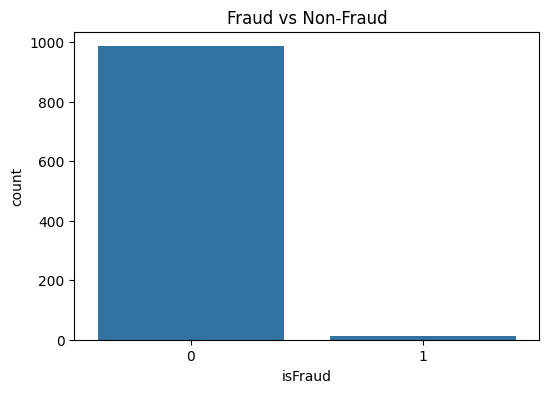

In [ ]:
plt.figure(figsize=(6,4))
sns.countplot(x="isFraud", data=df_pd)
plt.title("Fraud vs Non-Fraud")
plt.show()

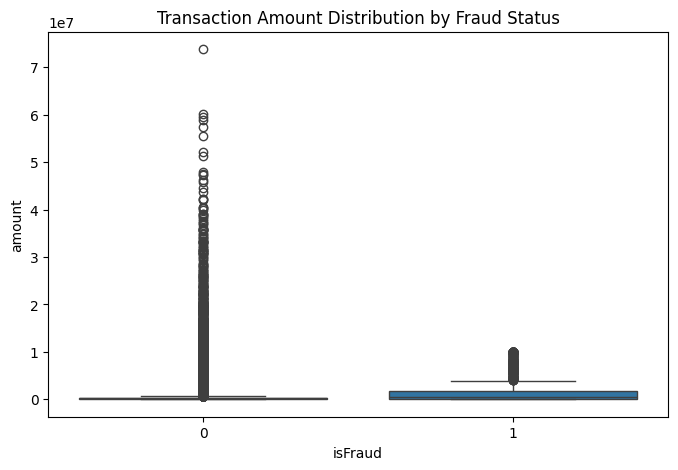

In [ ]:

sample_df = df_filtered.select("amount", "isFraud").sample(fraction=0.2).toPandas()

# Plot
plt.figure(figsize=(8, 5))
sns.boxplot(x="isFraud", y="amount", data=sample_df)

plt.title("Transaction Amount Distribution by Fraud Status")
plt.show()


This shows that the transctions for larger amounts are not fraud , but small amount is Fraud

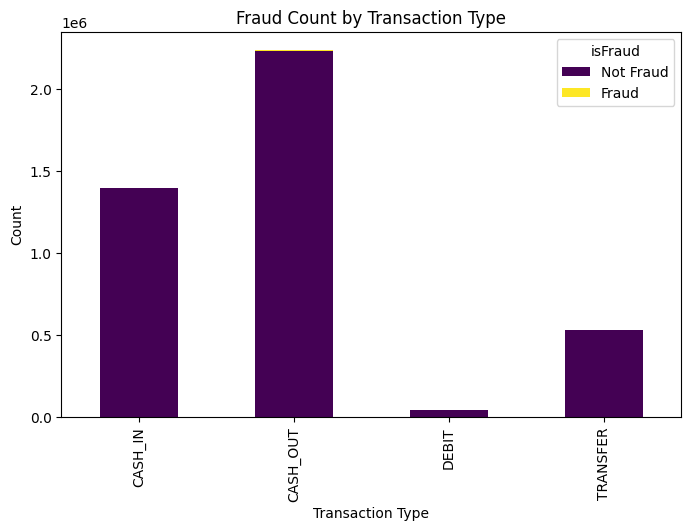

In [ ]:

type_fraud = df_filtered.groupBy("type", "isFraud").count().toPandas()

pivot_df = type_fraud.pivot(index="type", columns="isFraud", values="count")

# Plot
pivot_df.plot(kind="bar", stacked=True, figsize=(8, 5), colormap="viridis")
plt.title("Fraud Count by Transaction Type")
plt.xlabel("Transaction Type")
plt.ylabel("Count")
plt.legend(title="isFraud", labels=["Not Fraud", "Fraud"])
plt.show()


Fraud is when transction type is cash out and transfer

In [ ]:
pivot_df

isFraud,0,1
type,,
CASH_IN,1399284.0,NaN
CASH_OUT,2233384.0,4116.0
DEBIT,41432.0,NaN
TRANSFER,528812.0,4097.0


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


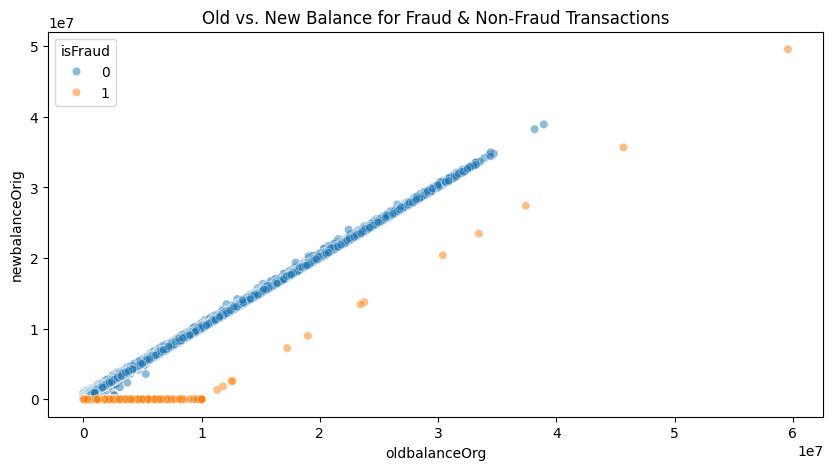

In [ ]:

sample_df = df.select("oldbalanceOrg", "newbalanceOrig", "isFraud").sample(fraction=0.1).toPandas()

plt.figure(figsize=(10, 5))
sns.scatterplot(x="oldbalanceOrg", y="newbalanceOrig", hue="isFraud", alpha=0.5, data=sample_df)
plt.title("Old vs. New Balance for Fraud & Non-Fraud Transactions")
plt.show()


for fraud , after cash transaction new balance is zero for most cases and some cases new balance is less than old balance which should be the case becasue cash is being withdrawn


In [ ]:
from pyspark.ml.feature import StringIndexer, VectorAssembler
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
indexer = StringIndexer(inputCol="type", outputCol="type_index")
df = indexer.fit(df_filtered).transform(df_filtered)

In [ ]:
feature_cols = ["type_index", "amount", "oldbalanceOrg", "newbalanceOrig", "oldbalanceDest", "newbalanceDest"]
assembler = VectorAssembler(inputCols=feature_cols, outputCol="features")
df = assembler.transform(df)

In [ ]:
df.columns

['step',
 'type',
 'amount',
 'nameOrig',
 'oldbalanceOrg',
 'newbalanceOrig',
 'nameDest',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'isFlaggedFraud',
 'type_index',
 'features']

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'type_index',
 'features']

In [ ]:
df = df.drop("type", "isFlaggedFraud", "nameOrig", "nameDest")



In [ ]:
df.columns

['step',
 'amount',
 'oldbalanceOrg',
 'newbalanceOrig',
 'oldbalanceDest',
 'newbalanceDest',
 'isFraud',
 'type_index',
 'features']

In [ ]:
train, test = df.randomSplit([0.8, 0.2], seed=42)


In [ ]:
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier, GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator

In [ ]:
lr = LogisticRegression(labelCol="isFraud", featuresCol="features")
lr_model = lr.fit(train)
lr_predictions = lr_model.transform(test)
evaluator = BinaryClassificationEvaluator(labelCol="isFraud")
lr_auc = evaluator.evaluate(lr_predictions)
print(f"Logistic Regression AUC: {lr_auc}")

Logistic Regression AUC: 0.9851348384035841


In [ ]:
dt = DecisionTreeClassifier(labelCol="isFraud", featuresCol="features")
dt_model = dt.fit(train)
dt_predictions = dt_model.transform(test)
dt_auc = evaluator.evaluate(dt_predictions)
print(f"Decision Tree AUC: {dt_auc}")

Decision Tree AUC: 0.6310852440024147


In [ ]:
gbt = GBTClassifier(labelCol="isFraud", featuresCol="features", maxIter=50)
gbt_model = gbt.fit(train)
gbt_predictions = gbt_model.transform(test)
gbt_auc = evaluator.evaluate(gbt_predictions)
print(f"Gradient Boosted Trees AUC: {gbt_auc}")

Gradient Boosted Trees AUC: 0.997067750043548


In [ ]:
rf = RandomForestClassifier(labelCol="isFraud", featuresCol="features", numTrees=50)
model = rf.fit(train)
predictions = model.transform(test)

predictions.select("isFraud", "prediction", "probability").show(10)

+-------+----------+--------------------+
|isFraud|prediction|         probability|
+-------+----------+--------------------+
|      0|       0.0|[0.99955614871835...|
|      0|       0.0|[0.99955614871835...|
|      0|       0.0|[0.99951747469203...|
|      0|       0.0|[0.99935450491297...|
|      0|       0.0|[0.99939031841499...|
|      0|       0.0|[0.99960412271877...|
|      0|       0.0|[0.99946102586512...|
|      0|       0.0|[0.99946102586512...|
|      0|       0.0|[0.99955614871835...|
|      0|       0.0|[0.99955614871835...|
+-------+----------+--------------------+
only showing top 10 rows



In [ ]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
# Binary classification evaluator for AUC-ROC
evaluator_roc = BinaryClassificationEvaluator(labelCol="isFraud", metricName="areaUnderROC")
auc_roc = evaluator_roc.evaluate(predictions)

# F1-score, Precision, Recall
evaluator_f1 = MulticlassClassificationEvaluator(labelCol="isFraud", metricName="f1")
f1_score = evaluator_f1.evaluate(predictions)

evaluator_precision = MulticlassClassificationEvaluator(labelCol="isFraud", metricName="weightedPrecision")
precision = evaluator_precision.evaluate(predictions)

evaluator_recall = MulticlassClassificationEvaluator(labelCol="isFraud", metricName="weightedRecall")
recall = evaluator_recall.evaluate(predictions)

# Print the results
print(f"AUC-ROC: {auc_roc:.4f}")
print(f"F1-score: {f1_score:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


AUC-ROC: 0.9735
F1-score: 0.9992
Precision: 0.9993
Recall: 0.9993


Best model is Random Forest

Companies can implement the following measures:

Real-time Fraud Detection → Deploy machine learning models to flag suspicious transactions instantly since cash out and transfer shows fraud as 1 from the visualization

Multi-Factor Authentication (MFA) → Require OTPs for high-risk transactions.

Transaction Limits → Restrict the maximum amount per transaction.

User Behavior Monitoring → Identify unusual patterns, like frequent high-value transactions.

Blacklist Fraudulent Accounts → Use historical fraud data to block suspicious users.

How to Measure if Prevention Works?
Fraudulent Transaction Rate → Has the number of fraud cases decreased?

False Positives → Are we flagging too many legitimate transactions?

Customer Complaints → Has user experience improved?

Chargeback Rates → Are banks reversing fewer fraud-related transactions?
